# Whole brain data processing

### Making mask

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def force_bkill_dask():
    try:
        get_ipython().run_cell_magic('bash', '', 'bkill -q normal 0\n')
    except:
        get_ipython().run_cell_magic('bash', '', 'bjobs\n')

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [3]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
# save_root = '/nrs/ahrens/jing/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/processed'

### Set save folder to Ziqiang's folder

In [4]:
save_root = './processed'
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Preproecssing
This will generate the follow files at `save_root` folder
* `motion_fix_.h5` -- reference image
* `trans_affs.npy` -- affine transform
* `Y_2dnorm_ave.h5` -- average image after detrend
* `local_pca_data.zarr` -- local pca denoised image (This might be used a x4 file size comparing to the raw data), which can be removed afterwards

### Notes
* ZW -- (Rechunk from image to time) I used 500 cores, and it broke down several times, but it is still working (41 minutes on rechunks), try at least 700 cores as a start
* ZW -- (later steps) I used number of blocks + 1 as number of cores (this can be precomputed)
* ZW -- computation time of baseline linearly increases with x, y, and baseline_window in each block (about 30 min for 256 x 256 x 400)

In [6]:
nsplit = 8
baseline_percentile = 20  
baseline_window = 400   # number of frames
numCores = 1

In [ ]:
%%time
preprocessing(dir_root, save_root, numCores=numCores, window=baseline_window, percentile=baseline_percentile, nsplit=nsplit)

In [7]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


## Mask
Making a mask for data to decrease the number of computation in demix
* remove low intensity pixel
* remove low snr pixel
* remove low local pixel correlation pixels

This will generate the follow files at `save_root` folder
* `mask_map.h5` -- mask
* `local_correlation_map.h5` -- local correlation
* `masked_local_pca_data.zarr` -- df/f computation
* `masked_downsampled_local_pca_data.zarr` -- downsampled in time -> used for cell segmentation, which can be removed afterwards

### Note
* ZW -- intensity_percentile can be experimented using notebook `Test_for_pipeline_mask`
* ZW -- I used 50% for examplary data

In [ ]:
import zarr
import scipy.ndimage.filters as sfilter
from utils import intesity_mask
# Y_d_ave_ = zarr.open(f'{save_root}/Y_ave.zarr', 'r')
Y_d_ave_ = zarr.open(f'{save_root}/Y_max.zarr', 'r')
intensity_percentile = np.ones(Y_d_ave_.shape[0])*50
intensity_percentile[17] = 70
intensity_percentile[18] = 80
intensity_percentile[19] = 90
intensity_percentile[20] = 95
mask = np.zeros(Y_d_ave_.shape).astype('bool')
for n, n_ave_ in enumerate(Y_d_ave_):
    mask_ = intesity_mask(n_ave_, intensity_percentile[n])
    mask_median = sfilter.median_filter(mask_.squeeze().astype('int'), size=7) == 1
    mask[n] = mask_ & mask_median[:, :, None]

In [ ]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    # plt.imshow(mask[n].squeeze(), cmap='gray', alpha=0.7)
    plt.title(n)
    plt.show()

In [ ]:
z, x, y, _ = mask.shape
cluster, client = fdask.setup_workers(1)
mask = da.from_array(mask, chunks=(1, x//nsplit, y//nsplit, -1))

In [ ]:
mask_sum = mask.map_blocks(lambda v:v.sum()*np.ones((1, x//nsplit, y//nsplit, 1))).compute()>2500
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.imshow(mask_sum[n].squeeze(), cmap='gray', alpha=0.3)
    plt.title(n)
    plt.show()

In [ ]:
da.from_array((mask.compute() & mask_sum), chunks=(1, x//nsplit, y//nsplit, -1)).to_zarr(f'{save_root}/mask_map.zarr')

In [ ]:
mask = da.from_zarr(f'{save_root}/mask_map.zarr')

In [ ]:
mask

In [ ]:
for n, n_ave_ in enumerate(Y_d_ave_):
    int_ = intensity_percentile[n]
    _ = n_ave_.copy()
    _[~mask[n]] = np.nan
    plt.imshow(_.squeeze(), vmax=np.percentile(n_ave_, max(int_+3, 90)), vmin=np.percentile(n_ave_, int_))
    plt.title(n)
    plt.show()

In [ ]:
cluster.stop_all_jobs()

In [8]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


## Patch FB PCA

In [15]:
numCores = 1400
local_pca_on_mask(save_root, numCores=numCores)

Scheduler: tcp://10.36.60.41:41927
Dashboard link: http://10.36.60.41:40891/status


Worker tcp://10.36.111.14:44555 restart in Job 56407293. This can be due to memory issue.
Worker tcp://10.36.60.15:40618 restart in Job 56406987. This can be due to memory issue.
Worker tcp://10.36.111.39:35489 restart in Job 56407106. This can be due to memory issue.
Worker tcp://10.36.60.23:34975 restart in Job 56407158. This can be due to memory issue.
Worker tcp://10.36.60.27:33718 restart in Job 56407067. This can be due to memory issue.
Worker tcp://10.36.60.21:34613 restart in Job 56407078. This can be due to memory issue.
Worker tcp://10.36.60.22:34142 restart in Job 56407060. This can be due to memory issue.
Worker tcp://10.36.111.37:33051 restart in Job 56407335. This can be due to memory issue.
Worker tcp://10.36.60.21:45921 restart in Job 56407271. This can be due to memory issue.
Unknown job_id: 56408113 for worker tcp://10.36.60.39:43208
Unknown job_id: 56408084 for worker tcp://10.36.60.39:43133
Unknown job_id: 56408114 for worker tcp://10.36.60.39:37363
Unknown job_id: 

RuntimeError: Command exited with non-zero exit code.
Exit code: 255
Command:
bkill 56407483 56408319 56407175 56407537 56407137 56407234 56407786 56407351 56407731 56407181 56407468 56408103 56407605 56407340 56407131 56407855 56407451 56407821 56407511 56407300 56407940 56408194 56407017 56408208 56407322 56407165 56407160 56407306 56408229 56407286 56407583 56407021 56408216 56406981 56407931 56407272 56407120 56408053 56408331 56407813 56407343 56407243 56407121 56407882 56407173 56407735 56407891 56408107 56407910 56407219 56407319 56407140 56407519 56408155 56407136 56407434 56407667 56407484 56407606 56407252 56407645 56407406 56407608 56408228 56407118 56407783 56408193
stdout:
Job <56407483> is being terminated
Job <56408319> is being terminated
Job <56407175> is being terminated
Job <56407537> is being terminated
Job <56407137> is being terminated
Job <56407234> is being terminated
Job <56407786> is being terminated
Job <56407351> is being terminated
Job <56407731> is being terminated
Job <56407181> is being terminated
Job <56407468> is being terminated
Job <56408103> is being terminated
Job <56407605> is being terminated
Job <56407340> is being terminated
Job <56407131> is being terminated
Job <56407855> is being terminated
Job <56407451> is being terminated
Job <56407821> is being terminated
Job <56407511> is being terminated
Job <56407300> is being terminated
Job <56407940> is being terminated
Job <56408194> is being terminated
Job <56407017> is being terminated
Job <56408208> is being terminated
Job <56407322> is being terminated
Job <56407165> is being terminated
Job <56407160> is being terminated
Job <56407306> is being terminated
Job <56408229> is being terminated
Job <56407286> is being terminated
Job <56407583> is being terminated
Job <56407021> is being terminated
Job <56408216> is being terminated
Job <56406981> is being terminated
Job <56407931> is being terminated
Job <56407272> is being terminated
Job <56407120> is being terminated
Job <56408053> is being terminated
Job <56408331> is being terminated
Job <56407813> is being terminated
Job <56407343> is being terminated
Job <56407243> is being terminated
Job <56407121> is being terminated
Job <56407882> is being terminated
Job <56407173> is being terminated
Job <56407735> is being terminated
Job <56407891> is being terminated
Job <56408107> is being terminated
Job <56407910> is being terminated
Job <56407219> is being terminated
Job <56407319> is being terminated
Job <56407140> is being terminated
Job <56407519> is being terminated
Job <56408155> is being terminated
Job <56407136> is being terminated
Job <56407434> is being terminated
Job <56407484> is being terminated
Job <56407606> is being terminated
Job <56407252> is being terminated
Job <56407645> is being terminated
Job <56407406> is being terminated
Job <56407608> is being terminated
Job <56408228> is being terminated
Job <56407118> is being terminated
Job <56407783> is being terminated
Job <56408193> is being terminated

stderr:
Job <56407667>: Job has already finished



In [16]:
force_bkill_dask()

No unfinished job found in queue <normal>


JOBID      USER    STAT  QUEUE      FROM_HOST   EXEC_HOST   JOB_NAME   SUBMIT_TIME
56360674   weiz    RUN   interactiv c11u24      32*e10u31   /bin/bash  Mar 13 11:54


### Check PCA results

In [22]:
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
mask = da.from_zarr(f'{save_root}/mask_map.zarr')
Y_svd = da.from_zarr(f'{save_root}/masked_local_pca_data.zarr')
rand_block = (14, 2, 5, 0)
mask_ = mask.blocks[rand_block]
M = Y_d.blocks[rand_block].squeeze().compute(scheduler='threads')
M_pca = Y_svd.blocks[rand_block].squeeze().compute(scheduler='threads')

In [24]:
from fish_proc.utils.snr import correlation_pnr
Cn_, _ = correlation_pnr(M, skip_pnr=True)
Cn, _ = correlation_pnr(M_pca, skip_pnr=True)

Number of processes to parallel: 48
Number of processes to parallel: 48


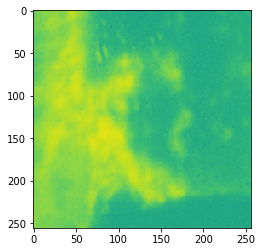

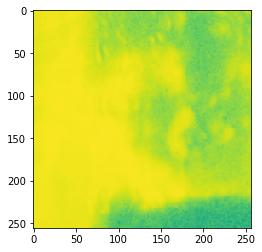

In [26]:
plt.imshow(Cn_, vmin=0, vmax=1)
plt.show()
plt.imshow(Cn, vmin=0, vmax=1)
plt.show()

In [ ]:
M = Y_d.blocks[8].squeeze().compute(scheduler='threads')
M_pca = Y_svd.blocks[8].squeeze().compute(scheduler='threads')

In [ ]:
Cn_, _ = correlation_pnr(M, skip_pnr=True)
Cn, _ = correlation_pnr(M_pca, skip_pnr=True)
plt.imshow(Cn_, vmin=0, vmax=1)
plt.show()
plt.imshow(Cn, vmin=0, vmax=1)
plt.show()

## Demix